In [1]:
pip install 'lightgbm[scikit-learn]'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from IPython.display import display

import statsmodels.api as sm
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

In [38]:
# Check versions for SMOTE 
'''
import scipy 
print(scipy.__version__)
import sklearn
print(sklearn.__version__)
import imblearn
print(imblearn.__version__)
'''

'\nimport scipy \nprint(scipy.__version__)\nimport sklearn\nprint(sklearn.__version__)\nimport imblearn\nprint(imblearn.__version__)\n'

In [39]:
def load_diabetes_data(path):
    # load in the original data
    diabetes_orig = pd.read_csv(path)

    # take just one person from each household
    diabetes = diabetes_orig.groupby("HHX") \
      .sample(1, random_state=24648765) \
      .reset_index() \
      .copy()
    # add an id column
    diabetes["id"] = np.arange(len(diabetes.index))
    # create the house_family_person_id column by joining together three ID columns
    diabetes["house_family_person_id"] = diabetes.apply(lambda x: "_".join(x[["HHX", "FMX", "FPX"]].astype(int).astype(str)), 
                                                        axis=1)
    # create the diabetes column
    diabetes["diabetes"] = (diabetes["DIBEV1"] == 1).astype(int)
    # create coronary heart disease column
    diabetes["coronary_heart_disease"] = (diabetes["CHDEV"] == 1).astype(int)
    # create hypertension column
    diabetes["hypertension"] = (diabetes["HYPEV"] == 1).astype(int)
    # create heart_condition column
    diabetes["heart_condition"] = (diabetes["HRTEV"] == 1).astype(int)
    # create cancer column
    diabetes["cancer"] = (diabetes["CANEV"] == 1).astype(int)
    # create family_history_diabetes column
    diabetes["family_history_diabetes"] = (diabetes["DIBREL"] == 1).astype(int)
    # rename remaining relevant columns
    diabetes = diabetes.rename(columns={"AGE_P": "age",
                                      "SMKEV": "smoker",
                                      "SEX": "sex",
                                      "AWEIGHTP": "weight",
                                      "BMI": "bmi",
                                      "AHEIGHT": "height"})

    # select just the relevant columns
    diabetes = diabetes[["house_family_person_id",
                        "diabetes",
                        "age",
                        "smoker",
                        "sex",
                        "coronary_heart_disease",
                        "weight",
                        "bmi",
                        "height",
                        "hypertension",
                        "heart_condition",
                        "cancer",
                        "family_history_diabetes"]]
    return(diabetes)

In [40]:
path = '../data/samadult.csv'
df = load_diabetes_data(path)

In [41]:
df

,house_family_person_id,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
0,1_2_1,0,24,2,2,0,125,2019,66,0,0,0,0
1,2_1_1,0,76,2,1,0,190,2727,70,1,0,0,0
2,3_1_2,0,36,2,2,0,225,3862,64,0,0,0,1
3,5_1_1,0,35,1,2,0,240,3995,65,0,0,0,1
4,10_1_5,0,20,2,2,0,103,1883,62,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32494,71559_1_1,0,56,1,1,0,172,2399,71,0,0,1,1
32495,71565_1_1,0,58,1,1,0,225,3141,71,1,0,0,1
32496,71569_1_1,1,71,1,2,1,124,2501,59,1,0,0,1
32497,71576_1_1,0,64,1,1,0,188,2945,67,1,0,0,0


In [42]:
# Create csv file of new df 
#df.to_csv('diabetes.csv', index=False)

In [43]:
# Checking for basic statistics and data information to understand the data better
data_info = df.info()
data_description = df.describe()

# Checking for missing values
missing_values = df.isnull().sum()

# Displaying the outputs
display(data_info, data_description, missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32499 entries, 0 to 32498
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   house_family_person_id   32499 non-null  object
 1   diabetes                 32499 non-null  int64 
 2   age                      32499 non-null  int64 
 3   smoker                   32499 non-null  int64 
 4   sex                      32499 non-null  int64 
 5   coronary_heart_disease   32499 non-null  int64 
 6   weight                   32499 non-null  int64 
 7   bmi                      32499 non-null  int64 
 8   height                   32499 non-null  int64 
 9   hypertension             32499 non-null  int64 
 10  heart_condition          32499 non-null  int64 
 11  cancer                   32499 non-null  int64 
 12  family_history_diabetes  32499 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 3.2+ MB


None

,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
count,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000
mean,0.107142,51.051017,1.608942,1.547494,0.055232,251.113850,3045.910736,68.817748,0.356042,0.089603,0.112865,0.354134
std,0.309298,18.511120,0.609761,0.497747,0.228437,240.280025,1451.552127,8.459210,0.478835,0.285616,0.316433,0.478257
min,0.000000,18.000000,1.000000,1.000000,0.000000,100.000000,1167.000000,59.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,1.000000,1.000000,0.000000,150.000000,2374.000000,64.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,52.000000,2.000000,2.000000,0.000000,176.000000,2724.000000,67.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,66.000000,2.000000,2.000000,0.000000,214.000000,3173.000000,70.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,85.000000,9.000000,2.000000,1.000000,999.000000,9999.000000,99.000000,1.000000,1.000000,1.000000,1.000000


house_family_person_id     0
diabetes                   0
age                        0
smoker                     0
sex                        0
coronary_heart_disease     0
weight                     0
bmi                        0
height                     0
hypertension               0
heart_condition            0
cancer                     0
family_history_diabetes    0
dtype: int64

In [44]:
# Check random rows 
display(df.sample(5))

# Check the anomily smoker counts
display(df['smoker'].value_counts())

,house_family_person_id,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
9306,20489_1_2,0,27,2,2,0,140,2826,59,0,0,0,1
14459,31730_1_1,0,29,2,2,0,130,2305,63,0,0,0,0
15355,33639_1_1,0,39,2,1,0,210,3393,66,0,0,0,1
27091,59596_1_2,0,39,1,2,1,110,1776,66,0,0,0,0
1211,2709_1_1,0,44,2,1,0,290,3721,74,0,0,0,0


smoker
2    19071
1    13325
8       59
7       23
9       21
Name: count, dtype: int64

In [45]:
def prepareDiabetesData(df, 
                          make_id_numeric=False,
                          rescale_bmi=True, 
                          fix_smoker_values=True, 
                          ohe_categorical=True, 
                          handle_outliers=True,
                          handle_imbalance=False,
                          age_binning=True, 
                          bmi_categorization=True):
    """
    Prepares the diabetes data based on action items.
    
    Parameters:
    df (pandas DataFrame): Input data
    make_id_numeric (bool): Whether to convert 'house_family_person_id' to numeric
    rescale_bmi (bool): Whether to fix BMI scale by dividing by 100
    fix_smoker_values (bool): Whether to fix inconsistent smoker values
    ohe_categorical (bool): Whether to perform one-hot encoding on categorical variables
        note: gender = 1 is Female, gender = 0 is Male 
    handle_outliers (bool): Whether to handle outliers in 'weight' and 'bmi'
    handle_imbalance (bool): Whether to handle diabetes class imbalance using SMOTE
    age_binning (bool): Whether to bin ages
    bmi_categorization (bool): Whether to categorize BMI into standard ranges
    
    Returns:
    pandas DataFrame: Cleaned and processed data
    """
    
    # Create a copy of the dataframe to ensure the original is untouched
    df_cleaned = df.copy()

    # 1. Convert 'house_family_person_id' to numeric
    if make_id_numeric:
        df_cleaned['house_family_person_id'] = pd.factorize(df_cleaned['house_family_person_id'])[0]

    # 2. Fix BMI scale (divide by 100)
    if rescale_bmi:
        df_cleaned['bmi'] = df_cleaned['bmi'] / 100

    # 3. Fix inconsistent smoker values
    if fix_smoker_values:
        df_cleaned['smoker'] = df_cleaned['smoker'].apply(lambda x: 2 if x > 2 else x)

    # 4. Handle outliers for weight and BMI using IQR (before SMOTE)
    if handle_outliers:
        def clip_outliers(col):
            """Clips outliers using the IQR method (1.5*IQR rule)."""
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return col.clip(lower=lower_bound, upper=upper_bound)
        
        df_cleaned['weight'] = clip_outliers(df_cleaned['weight'])
        df_cleaned['bmi'] = clip_outliers(df_cleaned['bmi'])

    # 5. Handle Diabetes Class Imbalance using SMOTE (before any categorical transformations)
    if handle_imbalance:
        smote = SMOTE(random_state=42)
        X = df_cleaned.drop('diabetes', axis=1)
        y = df_cleaned['diabetes']
        X_res, y_res = smote.fit_resample(X, y)
        df_cleaned = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['diabetes'])], axis=1)

    # 6. Bin Ages into categories (after SMOTE)
    if age_binning:
        df_cleaned['age_bin'] = pd.cut(df_cleaned['age'], bins=[18, 30, 50, 85], labels=['Under 30', '30-50', '50+'])
        if ohe_categorical:
            df_age_ohe = pd.get_dummies(df_cleaned['age_bin'], prefix='age')
            df_cleaned = pd.concat([df_cleaned, df_age_ohe], axis=1)
            df_cleaned.drop('age_bin', axis=1, inplace=True)

    # 7. Categorize BMI into standard medical categories (after SMOTE)
    if bmi_categorization:
        df_cleaned['bmi_category'] = pd.cut(df_cleaned['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')],
                                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        if ohe_categorical:
            df_bmi_ohe = pd.get_dummies(df_cleaned['bmi_category'], prefix='bmi')
            df_cleaned = pd.concat([df_cleaned, df_bmi_ohe], axis=1)
            df_cleaned.drop('bmi_category', axis=1, inplace=True)
    
    # 8. One-Hot Encode categorical variables (smoker, sex, BMI, and age bins)
    if ohe_categorical:
        # Apply OHE to smoker and sex columns
        ohe = OneHotEncoder(drop='first', sparse_output=False)
        # One-hot encode 'smoker' and 'sex'
        df_ohe = pd.DataFrame(ohe.fit_transform(df_cleaned[['smoker', 'sex']]),
                              columns=ohe.get_feature_names_out(['smoker', 'sex']))


        # Convert one-hot encoded columns to integers (0 or 1)
        df_ohe = df_ohe.astype(int)

        # Concatenate the new one-hot encoded columns back to the original dataframe
        df_cleaned = pd.concat([df_cleaned, df_ohe], axis=1)

        # Drop the original 'smoker' and 'sex' columns
        df_cleaned.drop(['smoker', 'sex'], axis=1, inplace=True)
        
        # Rename for clarity
        df_cleaned.rename(columns={'smoker_2': 'smoker', 'sex_2': 'gender'}, inplace=True)
    
    return df_cleaned  # Return the cleaned dataframe

In [46]:
df_cleaned = prepareDiabetesData(df, 
                                 make_id_numeric=True,
                          rescale_bmi=True, 
                          fix_smoker_values=True, 
                          ohe_categorical=True, 
                          handle_outliers=True,
                          handle_imbalance=True,
                          age_binning=True, 
                          bmi_categorization=True)

In [47]:
display(df_cleaned)
display(df_cleaned.shape)

,house_family_person_id,age,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes,diabetes,age_Under 30,age_30-50,age_50+,bmi_Underweight,bmi_Normal,bmi_Overweight,bmi_Obese,smoker,gender
0,0,24,0,125,20.190000,66,0,0,0,0,0,True,False,False,False,True,False,False,1,1
1,1,76,0,190,27.270000,70,1,0,0,0,0,False,False,True,False,False,True,False,1,0
2,2,36,0,225,38.620000,64,0,0,0,1,0,False,True,False,False,False,False,True,1,1
3,3,35,0,240,39.950000,65,0,0,0,1,0,False,True,False,False,False,False,True,0,1
4,4,20,0,103,18.830000,62,0,0,0,1,0,True,False,False,False,True,False,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58029,6215,70,0,195,34.727673,62,1,0,0,1,1,False,False,True,False,False,False,True,1,1
58030,6242,69,0,202,29.393710,69,1,0,0,1,1,False,False,True,False,False,True,False,0,0
58031,28201,61,1,241,37.830092,67,1,0,0,0,1,False,False,True,False,False,False,True,1,0
58032,18998,84,0,143,25.787966,62,1,0,0,0,1,False,False,True,False,False,True,False,1,1


(58034, 20)

In [48]:
display(df_cleaned.columns)

Index(['house_family_person_id', 'age', 'coronary_heart_disease', 'weight',
       'bmi', 'height', 'hypertension', 'heart_condition', 'cancer',
       'family_history_diabetes', 'diabetes', 'age_Under 30', 'age_30-50',
       'age_50+', 'bmi_Underweight', 'bmi_Normal', 'bmi_Overweight',
       'bmi_Obese', 'smoker', 'gender'],
      dtype='object')

## Prediction

In [49]:
df_cleaned.head()

,house_family_person_id,age,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes,diabetes,age_Under 30,age_30-50,age_50+,bmi_Underweight,bmi_Normal,bmi_Overweight,bmi_Obese,smoker,gender
0,0,24,0,125,20.19,66,0,0,0,0,0,True,False,False,False,True,False,False,1,1
1,1,76,0,190,27.27,70,1,0,0,0,0,False,False,True,False,False,True,False,1,0
2,2,36,0,225,38.62,64,0,0,0,1,0,False,True,False,False,False,False,True,1,1
3,3,35,0,240,39.95,65,0,0,0,1,0,False,True,False,False,False,False,True,0,1
4,4,20,0,103,18.83,62,0,0,0,1,0,True,False,False,False,True,False,False,1,1


In [50]:
print(df_cleaned.shape)

(58034, 20)


In [51]:
# Save the DataFrame to a CSV file
df.to_csv('diabetes_cleaned.csv', index=False)

In [52]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [53]:
import statsmodels.api as sm

# Ensure categorical columns are properly encoded using one-hot encoding
df_cleaned_2 = df_cleaned

# Replace "true"/"false" with 1/0 in the specified columns
df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']] = df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']].replace({True: 1, False: 0})

df_cleaned_2.head()

/var/folders/pn/d006c06d1r75x7885zwbf6kc0000gn/T/ipykernel_10027/120928731.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']] = df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']].replace({True: 1, False: 0})


,house_family_person_id,age,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes,diabetes,age_Under 30,age_30-50,age_50+,bmi_Underweight,bmi_Normal,bmi_Overweight,bmi_Obese,smoker,gender
0,0,24,0,125,20.19,66,0,0,0,0,0,1,0,0,False,True,False,False,1,1
1,1,76,0,190,27.27,70,1,0,0,0,0,0,0,1,False,False,True,False,1,0
2,2,36,0,225,38.62,64,0,0,0,1,0,0,1,0,False,False,False,True,1,1
3,3,35,0,240,39.95,65,0,0,0,1,0,0,1,0,False,False,False,True,0,1
4,4,20,0,103,18.83,62,0,0,0,1,0,1,0,0,False,True,False,False,1,1


### Logistic Regression

In [23]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Define independent (X) and dependent (y) variables
X = df_cleaned_2[['age', 'coronary_heart_disease', 'weight', 'bmi', 'height', 'hypertension',
                  'heart_condition', 'cancer', 'family_history_diabetes', 'smoker', 'gender']]
y = df_cleaned_2['diabetes']

# List of continuous variables and binary variables
continuous_vars = ['age', 'weight', 'bmi', 'height']
binary_vars = ['coronary_heart_disease', 'hypertension', 'heart_condition', 'cancer', 
               'family_history_diabetes', 'smoker', 'gender']

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 3: Create interaction terms and polynomial features (degree 2)
# Apply PolynomialFeatures to both continuous and binary variables
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 4: Scale only the continuous variables
scaler = StandardScaler()

# Extract continuous features from the polynomial transformation
continuous_indices = [i for i, col in enumerate(poly.get_feature_names_out(X.columns)) 
                      if any(var in col for var in continuous_vars)]
binary_indices = [i for i in range(len(poly.get_feature_names_out(X.columns))) if i not in continuous_indices]

# Scale only continuous variables in the transformed data
X_train_poly_continuous = X_train_poly[:, continuous_indices]
X_test_poly_continuous = X_test_poly[:, continuous_indices]

# Apply scaling to continuous features
X_train_poly_continuous_scaled = scaler.fit_transform(X_train_poly_continuous)
X_test_poly_continuous_scaled = scaler.transform(X_test_poly_continuous)

# Rebuild the full dataset, keeping the binary variables unscaled
X_train_scaled = X_train_poly.copy()
X_train_scaled[:, continuous_indices] = X_train_poly_continuous_scaled

X_test_scaled = X_test_poly.copy()
X_test_scaled[:, continuous_indices] = X_test_poly_continuous_scaled

# Step 5: Convert to DataFrame and add column names
# Get the feature names from PolynomialFeatures
feature_names = poly.get_feature_names_out(X.columns)

# Create DataFrame for scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Step 6: Add a constant term for the intercept
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

# Step 7: Reset indices to ensure alignment between X and y
X_train_scaled_df = X_train_scaled_df.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 8: Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_scaled_df)
result = logit_model.fit()

# Step 9: Display the regression summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.437644
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                40623
Model:                          Logit   Df Residuals:                    40552
Method:                           MLE   Df Model:                           70
Date:                Mon, 04 Nov 2024   Pseudo R-squ.:                  0.3686
Time:                        18:07:40   Log-Likelihood:                -17778.
converged:                       True   LL-Null:                       -28158.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                               

In [24]:
# Step 1: Get the model coefficients, standard errors, and p-values
params = result.params  # This gives you the coefficients
standard_errors = result.bse  # This gives you the standard errors (std dev)
p_values = result.pvalues  # This gives you the p-values

# Step 2: Select the first 11 regressors (plus the constant)
selected_params = params[:12]  # The first 11 regressors plus the constant
selected_standard_errors = standard_errors[:12]  # The standard errors for these
selected_p_values = p_values[:12]  # The p-values for these

# Step 3: Create a DataFrame to display the results, including p-values
summary_df = pd.DataFrame({
    'Regressor': selected_params.index,
    'Coefficient': selected_params.values,
    'Standard Error': selected_standard_errors.values,
    'p-value': selected_p_values.values
})

# Display the result
print(summary_df)

                  Regressor  Coefficient  Standard Error       p-value
0                     const    -0.536017    3.313281e-01  1.057094e-01
1                       age     4.432171    2.876327e-01  1.421083e-53
2    coronary_heart_disease     1.591856    6.302019e+07  1.000000e+00
3                    weight    -3.463078    5.882194e-01  3.923352e-09
4                       bmi     1.169060    6.153356e-01  5.744965e-02
5                    height    -3.207272    6.658798e-01  1.460307e-06
6              hypertension     0.122247             NaN           NaN
7           heart_condition    -0.676966    2.929273e+07  1.000000e+00
8                    cancer    -0.133759    4.287281e+06  1.000000e+00
9   family_history_diabetes     0.515382             NaN           NaN
10                   smoker    -0.403694    9.776760e+04  9.999967e-01
11                   gender    -0.239419    2.741744e-01  3.825337e-01


In [25]:
# Step 10: Predict probabilities on the test set
logit_probs_test = result.predict(X_test_scaled_df)

# Step 11: Convert predicted probabilities to binary (0 or 1) using a threshold of 0.5
logit_preds_test = (logit_probs_test > 0.5).astype(int)

# Step 12: Calculate the F1 score
f1 = f1_score(y_test, logit_preds_test)
print(f"F1 Score (Logit Model on Test Data): {f1:.4f}")

F1 Score (Logit Model on Test Data): 0.7989


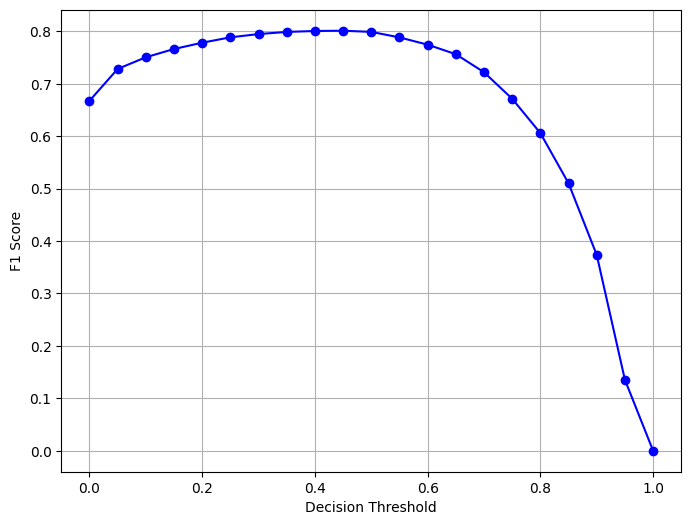

Best Threshold: 0.45, Best F1 Score: 0.8011


In [26]:
# Step 11: Define thresholds and calculate F1 scores at each threshold
thresholds = np.arange(0, 1.05, 0.05)
f1_scores = []

for threshold in thresholds:
    # Step 12: Convert predicted probabilities to binary using the threshold
    logit_preds_test = (logit_probs_test >= threshold).astype(int)
    
    # Calculate the F1 score for the current threshold
    f1 = f1_score(y_test, logit_preds_test)
    f1_scores.append(f1)

# Step 13: Find the threshold with the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1_score:.4f}")

F1 Score (Logit Model on Test Data): 0.8011
AUC Score (Logit Model on Test Data): 0.8743


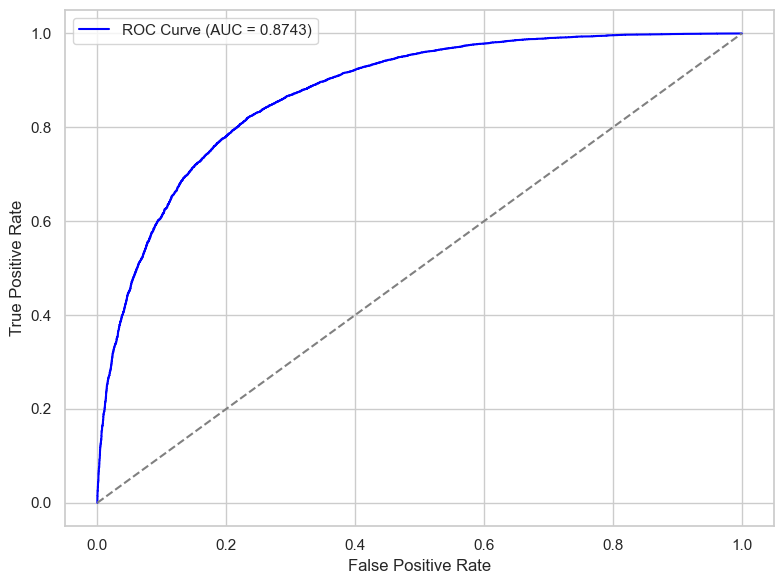

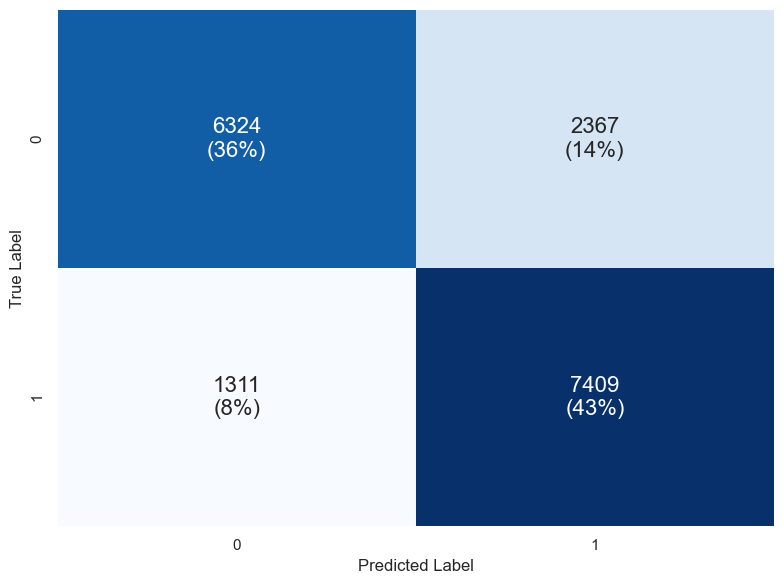

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Step 10: Predict probabilities on the test set
logit_probs_test = result.predict(X_test_scaled_df)

# Step 11: Convert predicted probabilities to binary (0 or 1) using a threshold of 0.5
logit_preds_test = (logit_probs_test > 0.45).astype(int)

# Step 12: Calculate the F1 score
f1 = f1_score(y_test, logit_preds_test)
print(f"F1 Score (Logit Model on Test Data): {f1:.4f}")

# Step 13: ROC Curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, logit_probs_test)  # Get False Positive Rate and True Positive Rate
auc_score = roc_auc_score(y_test, logit_probs_test)  # AUC score
print(f"AUC Score (Logit Model on Test Data): {auc_score:.4f}")

# Step 14: Confusion Matrix
cm = confusion_matrix(y_test, logit_preds_test)

# Step 15: Prepare counts and percentages for the confusion matrix
group_counts = [f"{value:0.0f}" for value in cm.flatten()]
group_percentages = [f"({value:.0%})" for value in cm.flatten() / np.sum(cm)]

# Step 16: Create combined labels with counts and percentages in brackets
labels = [f"{count}\n{percent}" for count, percent in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

In [27]:

# Step 15: Calculate the marginal effects
marginal_effects = result.get_margeff(at='overall', method='dydx')  # Average marginal effects

# Step 16: Display the marginal effects summary
print(marginal_effects.summary())

        Logit Marginal Effects       
Dep. Variable:               diabetes
Method:                          dydx
At:                           overall
                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
age                                                0.6322      0.042     15.179      0.000       0.551       0.714
coronary_heart_disease                             0.2271   8.99e+06   2.53e-08      1.000   -1.76e+07    1.76e+07
weight                                            -0.4940      0.084     -5.869      0.000      -0.659      -0.329
bmi                                                0.1668      0.088      1.900      0.057      -0.005       0.339
height                                            -0.4575      0.096     -4.790      0.000      -0.645      -0.270
hypertension                               

/Users/eytanrozenblum/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))


/var/folders/pn/d006c06d1r75x7885zwbf6kc0000gn/T/ipykernel_10027/838869944.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=me_original_clean['dy/dx'], y=me_original_clean.index,


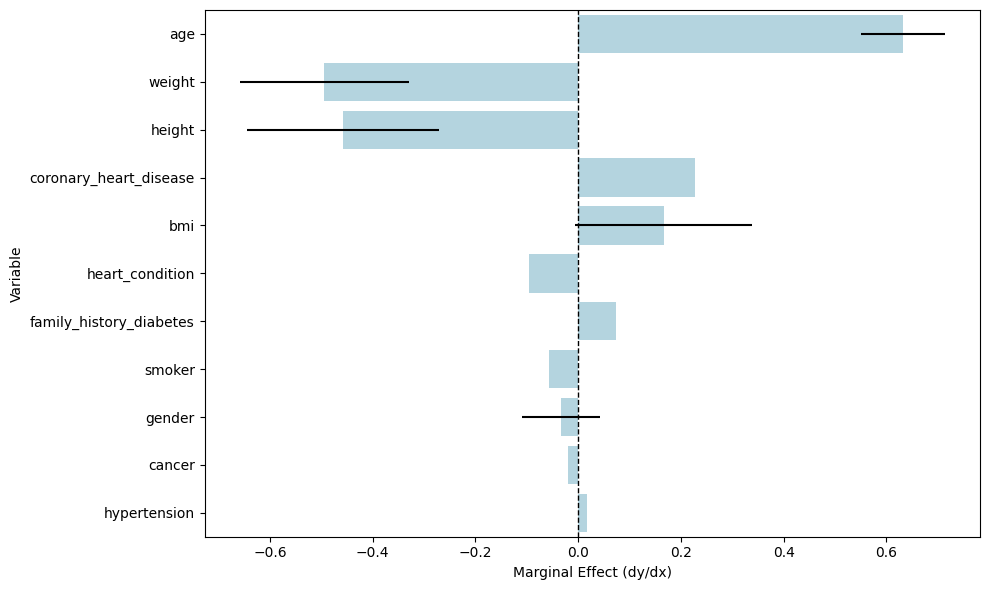

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the marginal effects values from the marginal effects summary
marginal_effects_df = marginal_effects.summary_frame()

# Step 2: Filter for the first 11 regressors (the original variables, not polynomial or interaction terms)
original_vars = ['age', 'coronary_heart_disease', 'weight', 'bmi', 'height', 
                 'hypertension', 'heart_condition', 'cancer', 
                 'family_history_diabetes', 'smoker', 'gender']

marginal_effects_original = marginal_effects_df.loc[original_vars]
me_original_clean = marginal_effects_original.reindex(marginal_effects_original['dy/dx'].abs().sort_values(ascending=False).index)

# Step 4: Calculate error bars (based on the 5% confidence intervals, i.e., 95% coverage in total)
# 5% confidence interval roughly corresponds to 1.645 * std err (instead of 1.96 for 95% CI)
error_bars = me_original_clean['Std. Err.'].apply(lambda x: 1.96 * x if x <= 10 else 0)

# Step 5: Plot the marginal effects as a bar chart with 5% confidence interval error bars using seaborn
plt.figure(figsize=(10, 6))

# Using sns.barplot with custom error bars for 5% CI and capsize
ax = sns.barplot(x=me_original_clean['dy/dx'], y=me_original_clean.index, 
                 estimator=np.mean, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')

# Step 6: Add labels for elements with std error > 10
#for i, row in me_original_clean.iterrows():
#    if row['Std. Err.'] > 10:
#        plt.text(max(me_original_clean['dy/dx']) - 0.02, i, 'std err ≥ 1E4', va='center', ha='left', color='red', fontsize=10)

# Customizing the plot
#plt.title('Marginal Effects of Variables on the Probability of Diabetes (with 5% CI)')
plt.xlabel('Marginal Effect (dy/dx)')
plt.ylabel('Variable')

# Add vertical line at 0 for reference
plt.axvline(x=0, color='black', linestyle='--', lw=1)

# Display the plot
plt.tight_layout()
plt.savefig('../output/logistic_regression_marginal_effects_balanced_SMOTE.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/pn/d006c06d1r75x7885zwbf6kc0000gn/T/ipykernel_10027/3935530768.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=top_10_me['dy/dx'], y=top_10_me.index, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')


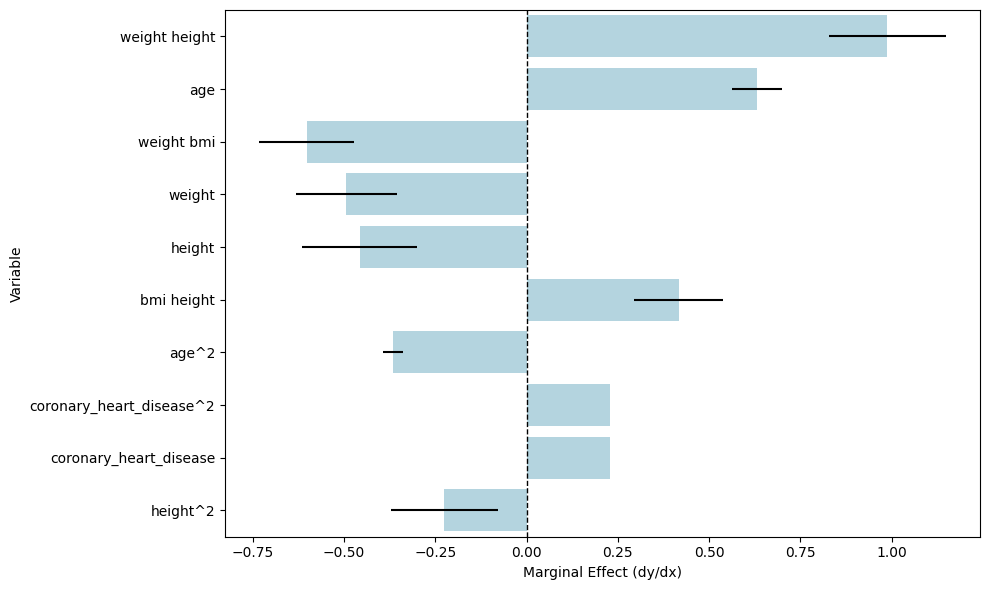

In [31]:
# Step 1: Get the marginal effects values from the marginal effects summary
marginal_effects_df = marginal_effects.summary_frame()

# Step 2: Sort all variables (including polynomial and interaction terms) by absolute marginal effect values
me_clean = marginal_effects_df.reindex(marginal_effects_df['dy/dx'].abs().sort_values(ascending=False).index)

# Step 3: Select the top 10 variables based on absolute marginal effects
top_10_me = me_clean.head(10)

# Step 4: Calculate error bars (based on the 5% confidence intervals)
error_bars = top_10_me['Std. Err.'].apply(lambda x: 1.645 * x if x <= 10 else 0)

# Step 5: Plot the marginal effects as a bar chart with 5% confidence interval error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_me['dy/dx'], y=top_10_me.index, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')

# Customizing the plot
plt.xlabel('Marginal Effect (dy/dx)')
plt.ylabel('Variable')
plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.tight_layout()
plt.savefig('../output/top_10_marginal_effects_balanced_SMOTE.png', dpi=300, bbox_inches='tight')
plt.show()